In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from datetime import datetime
from src import utils, plotting, scoring
from src.detector import CategoricalDriftDetector

Dados

In [27]:
# Parâmetros
n_samples = 100000 
n_features = 20  
n_informative = 2   # Número de características informativas
n_redundant = 2    # Número de características redundantes
weights = [0.2, 0.8]  # Desbalanceamento
np.random.seed(42)
# Gerar os dados
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           flip_y=0.05, 
                           random_state=42,
                           )

# Adicionar coluna com duas categorias
category_col = np.random.choice([0, 1], size=n_samples, p=weights)

# Adicionar coluna com diversas categorias (por exemplo, 5 categorias)
diverse_category_col = np.random.choice([0, 1, 2, 3, 4], size=n_samples)


In [28]:
# Criar DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['discrete_0'] = category_col
df['discrete_1'] = diverse_category_col
df['target'] = y
df['datetime'] = utils.generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [29]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

In [30]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

df_test

In [31]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

df_reference

In [32]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

In [33]:
result = scoring.metric_by_time_period(df_reference, 'W', 'target', 'prediction')

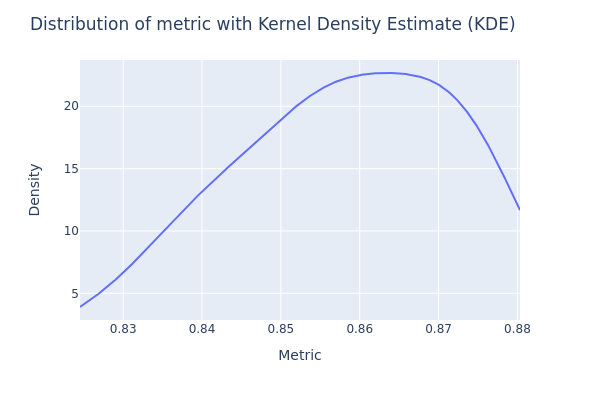

In [34]:
plotting.kde(result, 'metric', fig_type="png")


In [35]:
reference_metrics = scoring.reference_metrics_by_period(df_reference, "W", "target", "prediction")

In [36]:
reference_metrics

{'ci_lower': 0.849188170501541,
 'ci_upper': 0.8653173623584285,
 'mean': 0.8576626839240847,
 'lower_threshold': 0.8138709085875395,
 'upper_threshold': 0.90145445926063}

In [37]:
reference_score = scoring.metric_by_time_period(df_reference, 'W', 'target', 'prediction')

# Reference

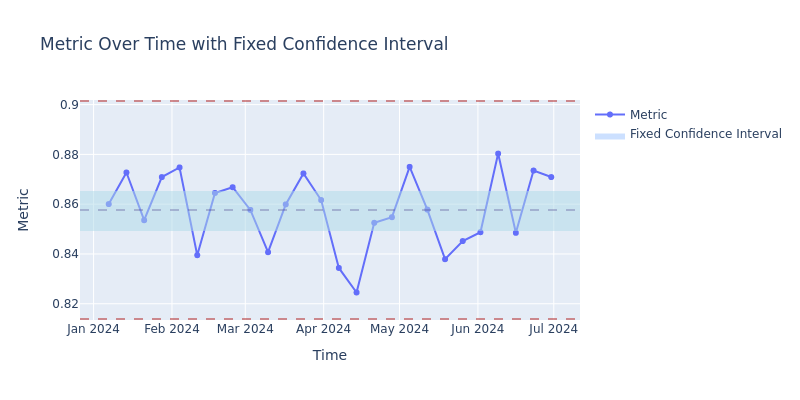

In [38]:
plotting.performance_by_time(reference_metrics, reference_score, fig_type="png")

# Analysis

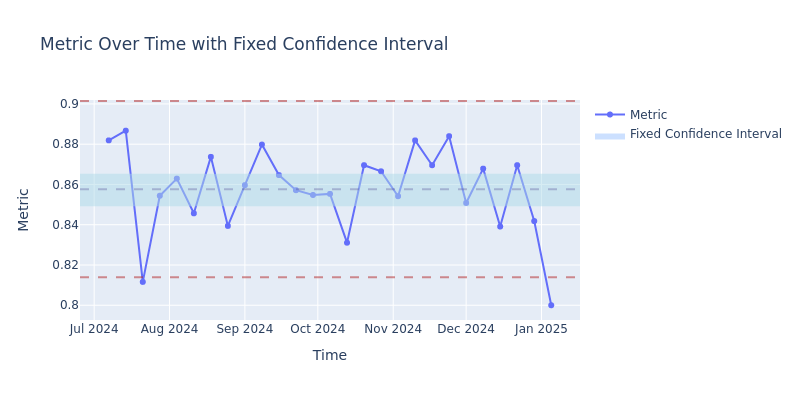

In [39]:
analysis_score = scoring.metric_by_time_period(df_test, 'W', 'target', 'prediction')
plotting.performance_by_time(reference_metrics, analysis_score, fig_type="png")

# Discrete Data Drift

In [40]:
# Exemplo de uso:
detector = CategoricalDriftDetector(df_reference, 'discrete_1', "W", "datetime")

In [41]:
test_distribution = detector._calculate_distribution(df_test, "W", "datetime")
test_distance = detector.generate_distance(test_distribution)

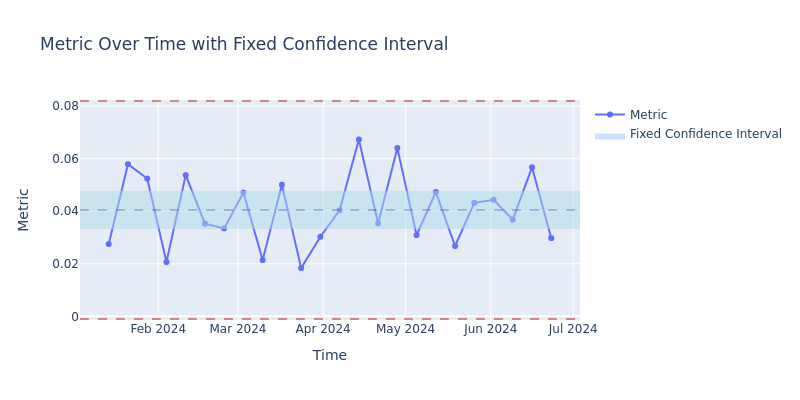

In [52]:
plotting.performance_by_time(detector.statistics, detector.reference_distance, fig_type="png")

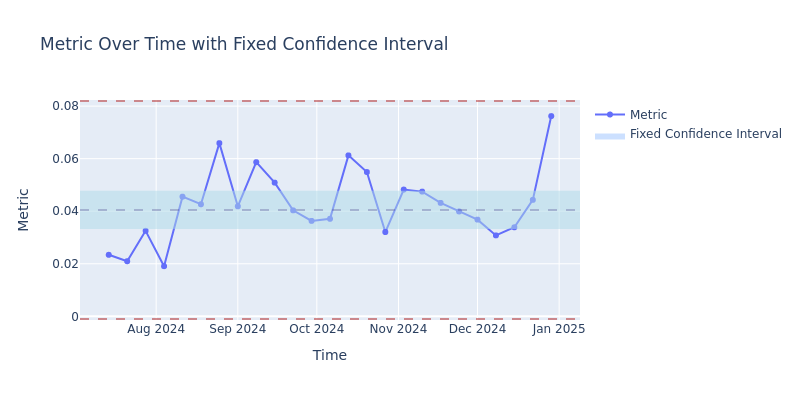

In [51]:
plotting.performance_by_time(detector.statistics, test_distance, fig_type="png")

# Continuous Data Drift

In [69]:
def calculate_continuous_distribution(df, column_name, period, timestamp):
    df = df[[timestamp, column_name]].copy()
    df = df.groupby(pd.Grouper(key="datetime", freq=period)).agg(list)[column_name]
    return df.iloc[:-1], df.iloc[1:]

In [79]:
from scipy.stats import ks_2samp

def ks_distance(a, b):
        """
        Compute the L-infinity distance between two distributions.
        """
        # Kolmogorov-Smirnov Test
        ks = np.vectorize(ks_2samp)
        idx = b.index
        ks_stat, _ = ks(a, b)
        return pd.Series(ks_stat.ravel(), index=idx, name="metric").reset_index()

In [81]:
def calculate_statistics(
        df, 
        statistic=np.mean,
        confidence_level=0.997,
        n_resamples=1000,
        random_state=42,):
        """
        Calculate statistics for the reference distances, including confidence intervals and thresholds.
        """
        ci_lower, ci_upper = scoring.bootstrapping_bca(
            df["metric"],
            confidence_level,
            statistic,
            n_resamples,
            random_state,
        )

        estimated_mean = np.mean(df["metric"])
        std_deviation = df["metric"].std()
        lower_threshold = estimated_mean - (3 * std_deviation)
        upper_threshold = estimated_mean + (3 * std_deviation)

        return {
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "mean": estimated_mean,
            "lower_threshold": lower_threshold,
            "upper_threshold": upper_threshold,
        }


In [91]:
a, b = calculate_continuous_distribution(df_reference, "feature_0", "W", "datetime")
ks_reference = ks_distance(a, b)
statistics = calculate_statistics(ks_reference)

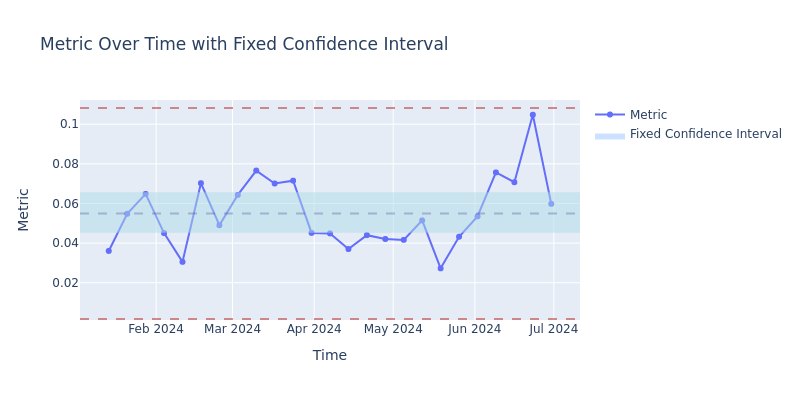

In [92]:
plotting.performance_by_time(statistics, ks_reference, fig_type="png")

In [93]:
a, b = calculate_continuous_distribution(df_test, "feature_0", "W", "datetime")
ks_test = ks_distance(a, b)

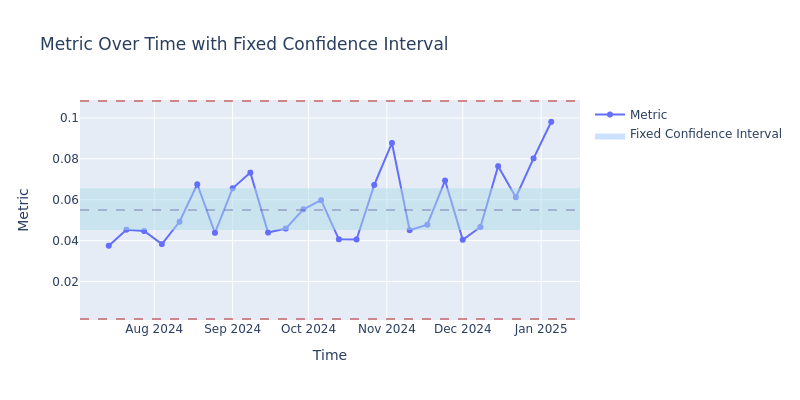

In [95]:
plotting.performance_by_time(statistics, ks_test, fig_type="png")